**This Notebook is a copy of C0CONUTS "Unet + ImageDataGenerator LB 0.336". Also trained vgg16 based unet using segmentation models.** 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

base_dir = "../input/data-science-bowl-2018"
train_dir = os.path.join(base_dir, "stage1_train.zip")
test_dir = os.path.join(base_dir, "stage1_test.zip")

import zipfile
with zipfile.ZipFile(train_dir,"r") as z:
    z.extractall("./stage1_train")

with zipfile.ZipFile(test_dir,"r") as z:
    z.extractall("./stage1_test")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-science-bowl-2018/stage1_test.zip
/kaggle/input/data-science-bowl-2018/stage1_sample_submission.csv.zip
/kaggle/input/data-science-bowl-2018/stage2_sample_submission_final.csv.zip
/kaggle/input/data-science-bowl-2018/stage1_train.zip
/kaggle/input/data-science-bowl-2018/stage1_train_labels.csv.zip
/kaggle/input/data-science-bowl-2018/stage1_solution.csv.zip
/kaggle/input/data-science-bowl-2018/stage2_test_final.zip


In [2]:
import os
import sys
import random
import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm
#tqdm provides a fast and extensible progress bar for loops and other iterable operations
#tqdm in arabic "taqaddum" which means progress
from itertools import chain
#Python module that provides various functions for working with iterators and iterable objects efficiently
from skimage.io import imread,imshow,imread_collection,concatenate_images
from skimage.transform import resize
# from skimage.morphology import label
from skimage import img_as_ubyte
#to convert an image from a floating-point representation to an unsigned byte representation 

from keras.models import Model,load_model
from keras.layers import Input,Dropout,Lambda,Conv2D,Conv2DTranspose,MaxPooling2D,concatenate
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.preprocessing import image
from keras import backend as K

import tensorflow as tf

BATCH_SIZE = 10
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNEL = 3
TRAIN_PATH = "./stage1_train/"
TEST_PATH = "./stage1_test/"

warnings.filterwarnings("ignore")
seed = 42

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# os.walk(path)
To iterate through the path and find all files and directories

In [3]:
train=next(os.walk(TRAIN_PATH))
print(train[0])

./stage1_train/


In [4]:
print(train[1][50])


97158b2fe38783d88d4e44ba1b7bc6c84f225f8b35fcccc2f9265c65f14e7c8b


In [5]:
print(train[2])

[]


In [6]:
path='./stage1_train/6d327ab4f0e3604fa6e9b8041c7e6db86ab809890d886c691f6e59c9168b7fbe/'

In [7]:
t=next(os.walk(path))

In [8]:
print(t[1])

['masks', 'images']


In [9]:
print(t[2])

[]


In [10]:
import os

def print_files_in_subfolders(path):
    # Get the list of subdirectories in the current directory
    subdirectories = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]

    # Iterate through the subdirectories
    for subdir in subdirectories:
        subdir_path = os.path.join(path, subdir)

        # Get the list of files in the subdirectory
        files = [f for f in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, f))]

        # Print the files in the subdirectory
        print(len(files))
        for file in files:
            print(os.path.join(subdir, file))

# Specify the path to the directory containing the two subfolders
start_path = path

# Call the function to print all files in the subfolders
print_files_in_subfolders(start_path)


17
masks/bb8c684cdc051b540026a3fdd6bd1b9b702072fe316de8f2cf72e098958fc640.png
masks/9ce7b9d318e90dcfc2ae8f88eab46fbb9f966dac29818e13b9c9c699f6b52af7.png
masks/f881681e30a7fd73232fdab11d7542822ab4a61e91209eaddda50ca29c326300.png
masks/7c729f65dff232564f2ddb5f3ff776ebe1fcea5f3434f4abb0f2126b352c99f2.png
masks/e4fccb0761829d00ec4eaf88e7ad005b8b0c0c01e22d9f48d1cd6369cf3755e8.png
masks/7a94475f23c975a89319425de32bfe3b62c001d4b10d6275d4777884ff01d0b5.png
masks/d4d7c3665f94cb70d1565c041263643eca0578e914b9d1e76a76706ec84fe11b.png
masks/5712aa23934945d02ffe7f4ac70e66e1b4daf5dc563d0aebaa92bdd6a2f2c9f1.png
masks/bc8e66a296185edc3a9da84acbb3469cc883f4a535a2d6c64e5ff343ca4efa5c.png
masks/e37b9dde570b240c61adb5ddd8d0a6d2faef635255391565e6564df0fbe08c73.png
masks/4ba2584837426c203b1095dcd8b65560c2eafb0e01683820b673dc435e67d707.png
masks/012b82522c68ed9e4cf7ad0e71e3f581adca1e4b57f889fe01da0dd8a620bb87.png
masks/c3098d355e85fc90b898005b220508db30eef40ada714be6c79dddb2c28a2a73.png
masks/062ae8dfff8e8643

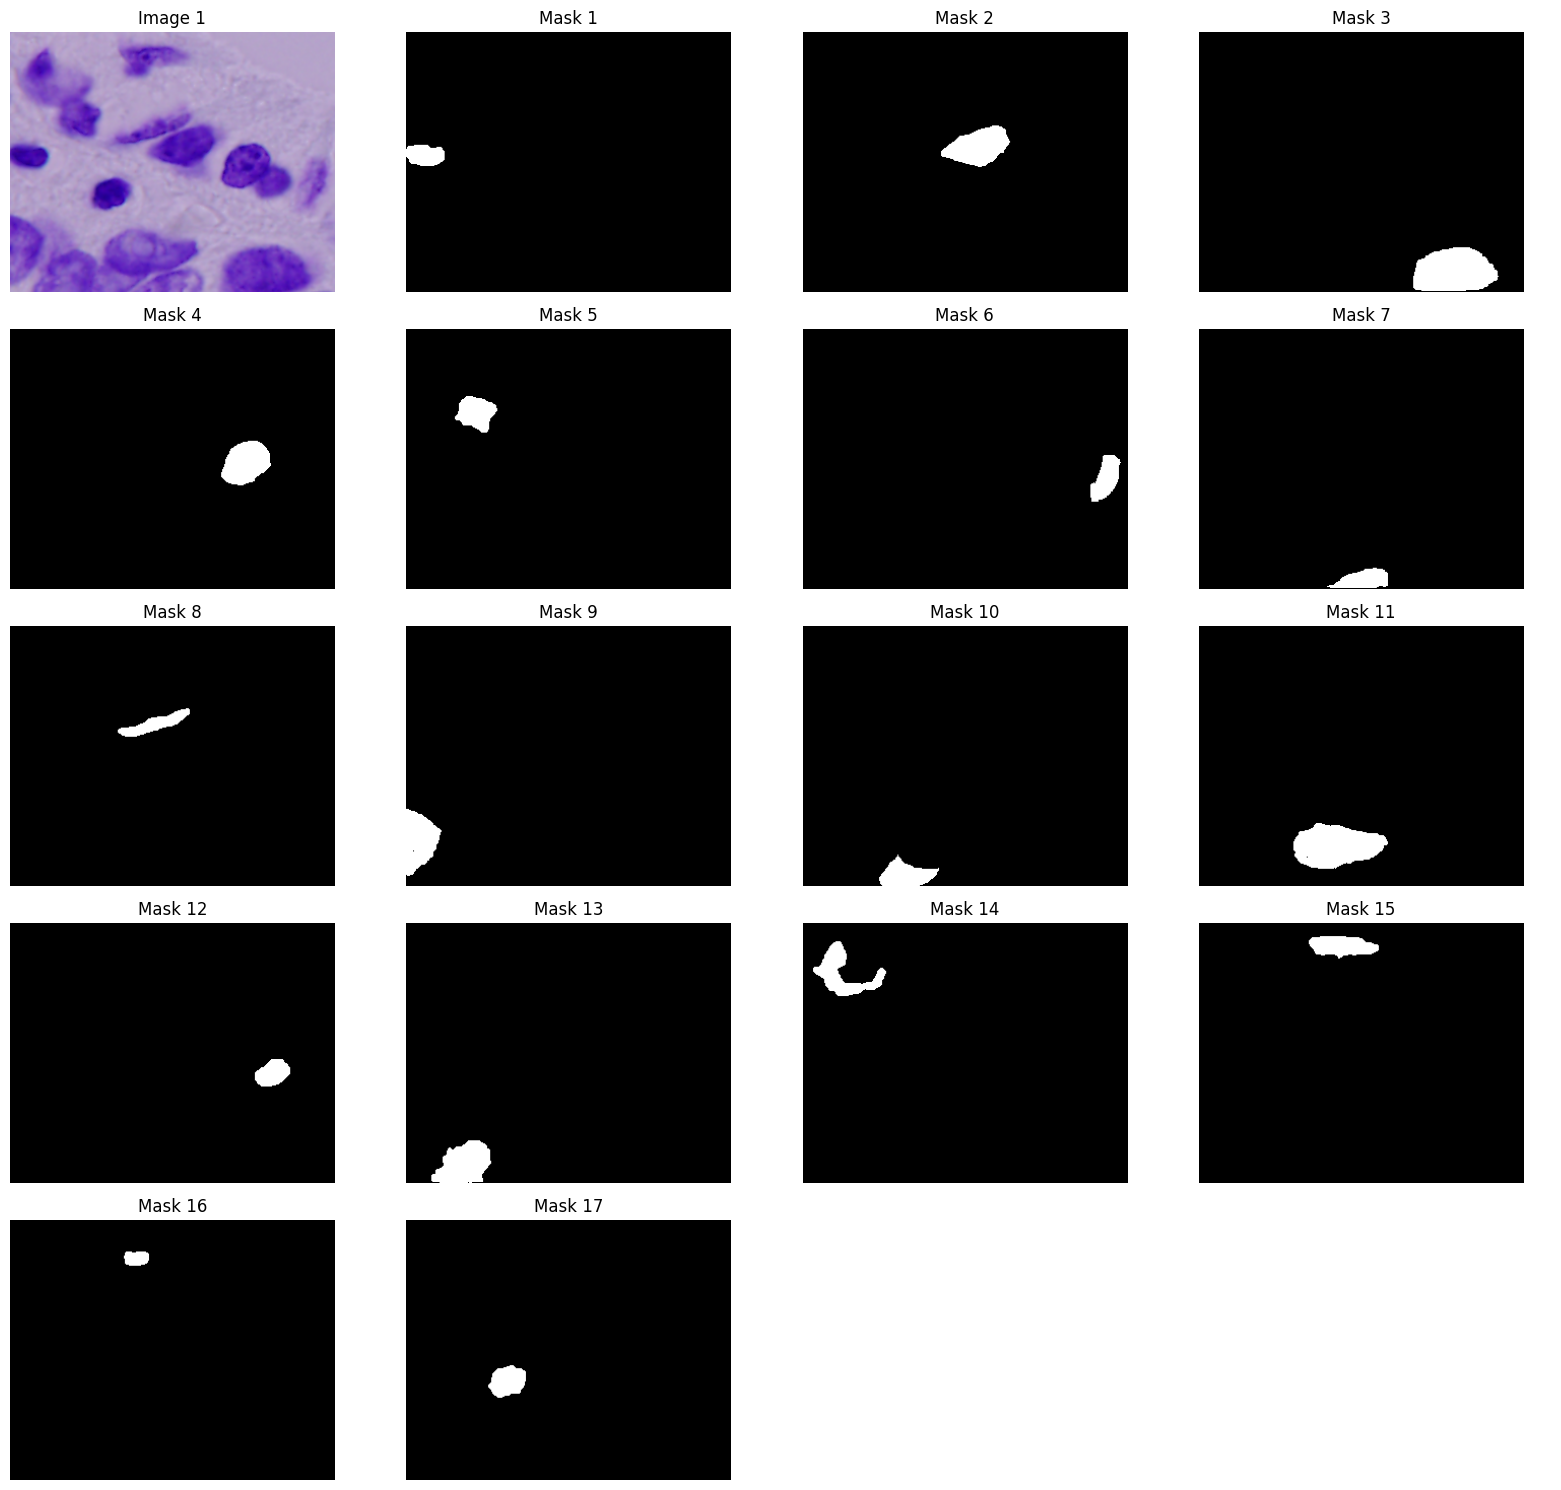

In [11]:
import os
import matplotlib.pyplot as plt
import cv2  # OpenCV for image processing

# Define the path to the folder containing the images and masks
folder_path = path

# Define paths to the 'images' and 'masks' folders
images_folder = os.path.join(folder_path, 'images')
masks_folder = os.path.join(folder_path, 'masks')

# List the image and mask files
image_files = os.listdir(images_folder)
mask_files = os.listdir(masks_folder)

# Calculate the number of rows and columns based on the number of files and a maximum of 4 columns
max_columns = 4
num_cols = min(len(image_files) + len(mask_files), max_columns)
num_rows = (len(image_files) + len(mask_files) + num_cols - 1) // num_cols

# Calculate the figure size based on the number of columns
fig_width = 4 * num_cols
fig_height = 3 * num_rows
fig, axes = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))

# Display the images and masks in the subplots
for i, image_file in enumerate(image_files):
    image_path = os.path.join(images_folder, image_file)
    image = cv2.imread(image_path)
    
    row = i // num_cols
    col = i % num_cols
    
    axes[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[row, col].set_title(f'Image {i + 1}')
    axes[row, col].axis('off')

for i, mask_file in enumerate(mask_files):
    mask_path = os.path.join(masks_folder, mask_file)
    mask = cv2.imread(mask_path)
    
    row = (i + len(image_files)) // num_cols
    col = (i + len(image_files)) % num_cols
    
    axes[row, col].imshow(mask, cmap='gray')
    axes[row, col].set_title(f'Mask {i + 1}')
    axes[row, col].axis('off')

# Hide any remaining empty subplots
for i in range(len(image_files) + len(mask_files), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

# Adjust subplot spacing
plt.tight_layout()
plt.show()


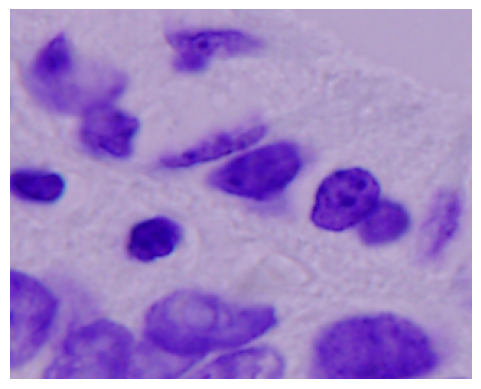

In [12]:
from matplotlib import pyplot as plt
%matplotlib inline

image_path = './stage1_train/6d327ab4f0e3604fa6e9b8041c7e6db86ab809890d886c691f6e59c9168b7fbe/images/6d327ab4f0e3604fa6e9b8041c7e6db86ab809890d886c691f6e59c9168b7fbe.png'
img =imread(image_path)
plt.imshow(img)
plt.axis('off')  # Optional: Turn off axis labels and ticks
plt.show()


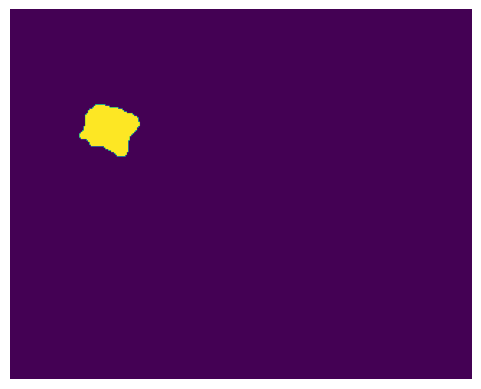

In [13]:
from matplotlib import pyplot as plt
%matplotlib inline

image_path = './stage1_train/6d327ab4f0e3604fa6e9b8041c7e6db86ab809890d886c691f6e59c9168b7fbe/masks/e4fccb0761829d00ec4eaf88e7ad005b8b0c0c01e22d9f48d1cd6369cf3755e8.png'
img = imread(image_path)
plt.imshow(img)
plt.axis('off')  # Optional: Turn off axis labels and ticks
plt.show()

In [14]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]
np.random.seed(10)

In [15]:
X_train = np.zeros((len(train_ids),IMG_HEIGHT,IMG_WIDTH,IMG_CHANNEL),dtype=np.uint8)
y_train = np.zeros((len(train_ids),IMG_HEIGHT,IMG_WIDTH,1),dtype=np.bool)

for n,_id in tqdm(enumerate(train_ids)):
    path = TRAIN_PATH + _id
    img = imread(path + "/images/" + _id + ".png")[:,:,:IMG_CHANNEL]
    img = resize(img,(IMG_HEIGHT,IMG_WIDTH),mode="constant",preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT,IMG_WIDTH,1),dtype=np.bool)
    for mask_file in next(os.walk(path + "/masks/") )[2]:
        mask_ = imread(path + "/masks/" + mask_file)
        mask_ = np.expand_dims( resize(mask_,(IMG_HEIGHT,IMG_WIDTH),mode="constant",preserve_range=True)
                              , axis=-1)
        mask = np.maximum(mask,mask_)
    y_train[n] = mask  
    
X_test = np.zeros((len(test_ids),IMG_HEIGHT,IMG_WIDTH,IMG_CHANNEL),dtype=np.uint8)
sizes_test = []
for n ,_id in tqdm(enumerate(test_ids)):
    path = TEST_PATH + _id
    img = imread(path + "/images/" + _id + ".png")[:,:,:IMG_CHANNEL]
    sizes_test.append([img.shape[0],img.shape[1]])
    img = resize(img,(IMG_HEIGHT,IMG_WIDTH),mode="constant",preserve_range=True)
    X_test[n] = img
    
print("Done!!")

670it [04:08,  2.69it/s]
65it [00:01, 48.69it/s]

Done!!


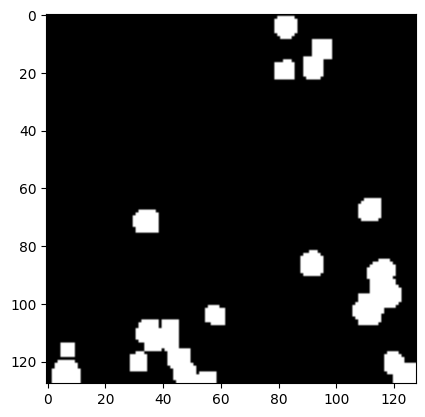

In [16]:
plt.imshow(y_train[99][:, :, 0], cmap='gray')


In [17]:
from keras.models import Model,load_model
from keras.layers import Input,Dropout,Lambda,Conv2D,Conv2DTranspose,MaxPooling2D,concatenate
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.preprocessing import image
from keras import backend as K

In [18]:
image_datagen = image.ImageDataGenerator(shear_range=0.5,rotation_range=50,zoom_range=0.2
                                         ,width_shift_range=0.2,height_shift_range=0.2,fill_mode="reflect")
mask_datagen = image.ImageDataGenerator(shear_range=0.5,rotation_range=50,zoom_range=0.2
                                         ,width_shift_range=0.2,height_shift_range=0.2,fill_mode="reflect")

image_datagen.fit(X_train[:int(X_train.shape[0]*0.9)],augment=True,seed = seed)
mask_datagen.fit(y_train[:int(y_train.shape[0]*0.9)],augment=True,seed = seed)

x = image_datagen.flow(X_train[:int(X_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True,seed=seed)
y = mask_datagen.flow(y_train[:int(y_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True,seed=seed)

image_datagen_val = image.ImageDataGenerator()
mask_datagen_val = image.ImageDataGenerator()

image_datagen_val.fit(X_train[int(X_train.shape[0]*0.9):],augment=True,seed = seed)
mask_datagen_val.fit(y_train[int(y_train.shape[0]*0.9):],augment=True,seed = seed)

x_val = image_datagen.flow(X_train[int(X_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True,seed=seed)
y_val = mask_datagen.flow(y_train[int(y_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True,seed=seed)


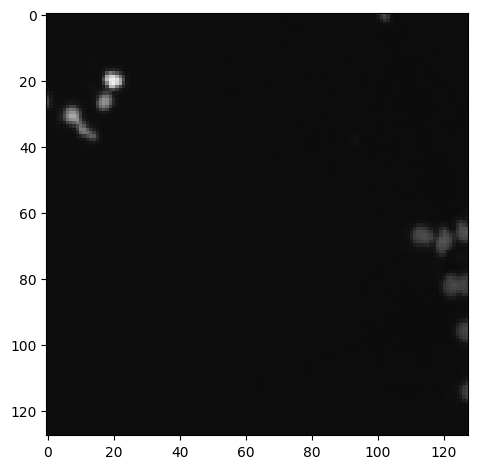

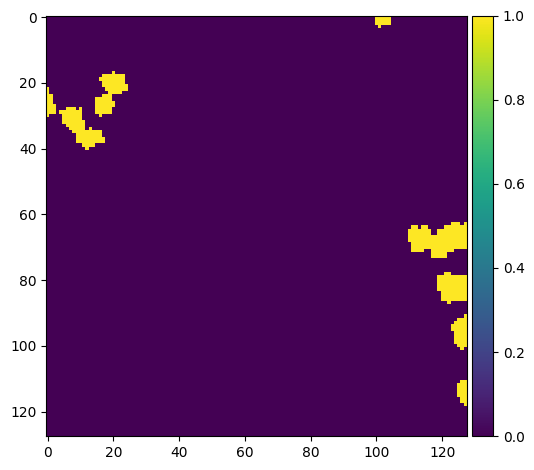

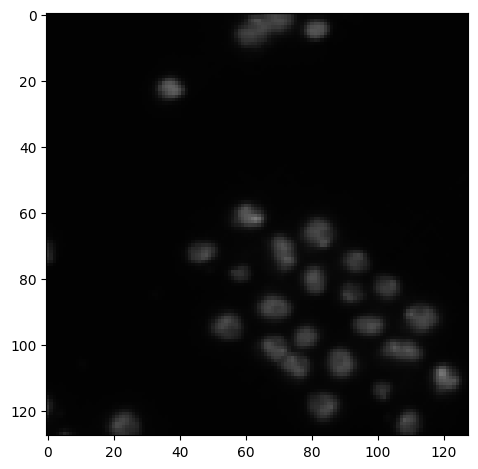

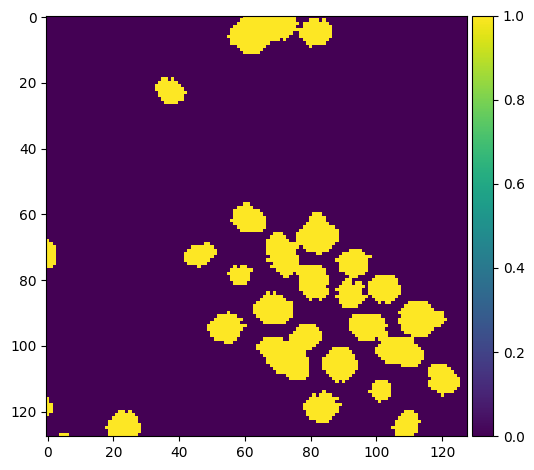

In [19]:
imshow(x.next()[0].astype(np.uint8))
plt.show()
imshow(np.squeeze(y.next()[0].astype(np.uint8)))
plt.show()
imshow(x_val.next()[0].astype(np.uint8))
plt.show()
imshow(np.squeeze(y_val.next()[0].astype(np.uint8)))
plt.show()

In [20]:
train_generator = zip(x,y)
val_generator = zip(x_val,y_val)

In [21]:
print(type(train_generator))

<class 'zip'>


In [22]:
def mean_iou(y_true, y_pred):
    y_true = tf.cast(y_true > 0.5, tf.int32) 
    # values to int >0.5 to 1 and <0.5 to 0
    y_pred = tf.cast(y_pred > 0.5, tf.int32)
    
    # Calculate the intersection (true positives)
    intersection = tf.reduce_sum(y_true * y_pred)
    #calculating the total number of true positives (TP) (1's).
    
    # Calculate the union (true positives + false positives + false negatives)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    #(TP + FN) + (TP + FP) - (TP)
    
    # Calculate the IoU for each class
    iou = intersection / union
    #the proportion of overlap between the predicted and true binary masks.
    # A higher IoU indicates better segmentation accuracy.
    
    
    return iou

In [23]:
from keras.models import Model,load_model
from keras.layers import Input,Dropout,Lambda,Conv2D,Conv2DTranspose,MaxPooling2D,concatenate
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.preprocessing import image
from keras import backend as K

import tensorflow as tf

In [24]:
# # Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
#defines thhe initial values of weights
#He_normal  initializes weights in a way that helps with training deep networks by reducing the risk of vanishing or exploding gradients.
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [25]:
earlyStopping = EarlyStopping(patience=3,verbose=1)
#EarlyStopping callback is used to monitor the training process and stop training early if a certain condition is met.
#patience: The number of consecutive epochs with no improvement after which training will be stopped.
#
# verbose 1 means that training progress messages will be printed.
modelCheckpoint = ModelCheckpoint("model-unet2023-1.h5",verbose=1,save_best_only=True)
#ModelCheckpoint callback is used to save the model's weights during training.

history = model.fit_generator(train_generator,validation_data=val_generator,validation_steps=10, steps_per_epoch=250,
                             epochs=100,callbacks=[earlyStopping,modelCheckpoint])
#model.fit_generator()function is used to train the neural network model using data generators (train_generator and val_generator)

Epoch 1/100


2023-10-11 05:36:52.111706: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


250/250 [==============================] - ETA: 0s - loss: 0.2999 - mean_iou: 0.5550
Epoch 1: val_loss improved from inf to 0.23063, saving model to model-unet2023-1.h5
250/250 [==============================] - 37s 74ms/step - loss: 0.2999 - mean_iou: 0.5550 - val_loss: 0.2306 - val_mean_iou: 0.7390
Epoch 2/100
250/250 [==============================] - ETA: 0s - loss: 0.1453 - mean_iou: 0.8035
Epoch 2: val_loss did not improve from 0.23063
250/250 [==============================] - 17s 66ms/step - loss: 0.1453 - mean_iou: 0.8035 - val_loss: 0.2916 - val_mean_iou: 0.7823
Epoch 3/100
250/250 [==============================] - ETA: 0s - loss: 0.1352 - mean_iou: 0.8172
Epoch 3: val_loss did not improve from 0.23063
250/250 [==============================] - 16s 63ms/step - loss: 0.1352 - mean_iou: 0.8172 - val_loss: 0.2809 - val_mean_iou: 0.7819
Epoch 4/100
250/250 [==============================] - ETA: 0s - loss: 0.1245 - mean_iou: 0.8322
Epoch 4: val_loss improved from 0.23063 to 0.22

In [26]:
model = load_model("model-unet2023-1.h5",custom_objects={"mean_iou":mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)],verbose=1)
preds_val  = model.predict(X_train[:int(X_train.shape[0]*0.1)],verbose=1)
preds_test = model.predict(X_test,verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append( resize(np.squeeze(preds_test_t[i]),
                                       (sizes_test[i][0],sizes_test[i][1]),
                                       mode = "constant",preserve_range=True) )

3/3 [==============================] - 0s 185ms/step


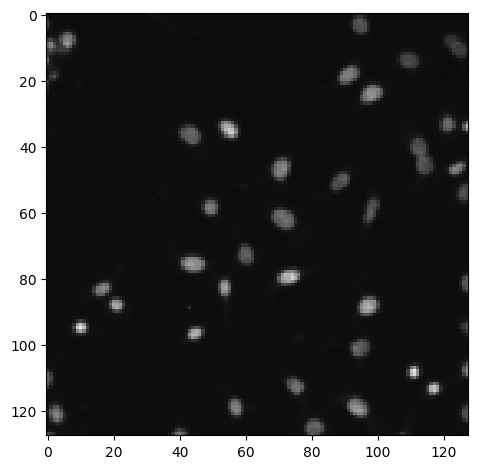

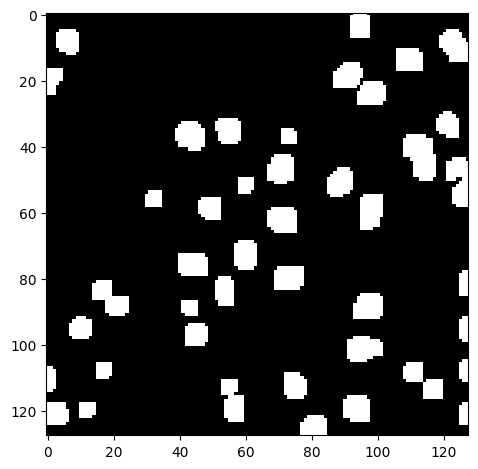

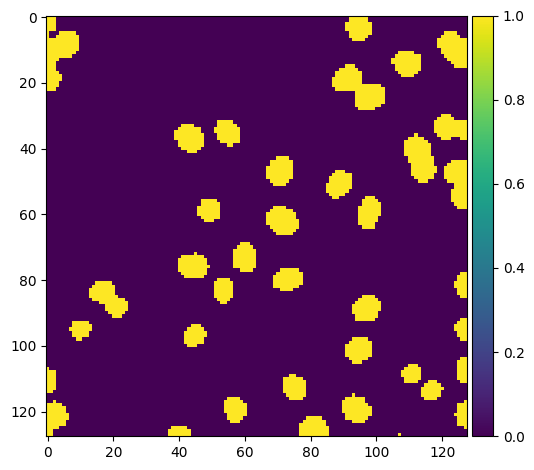

In [27]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

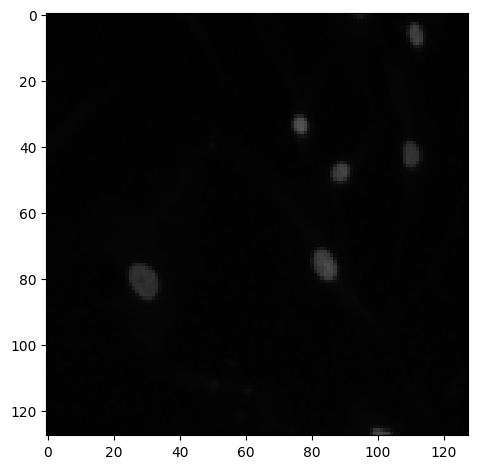

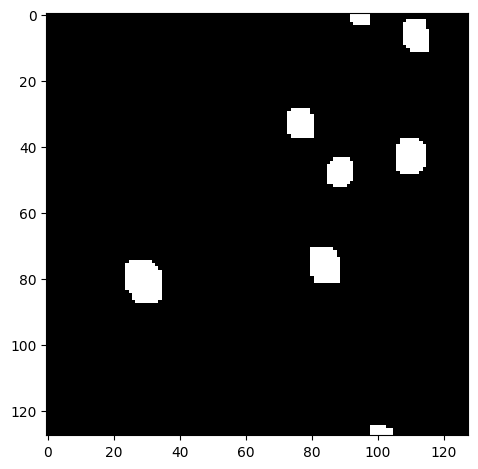

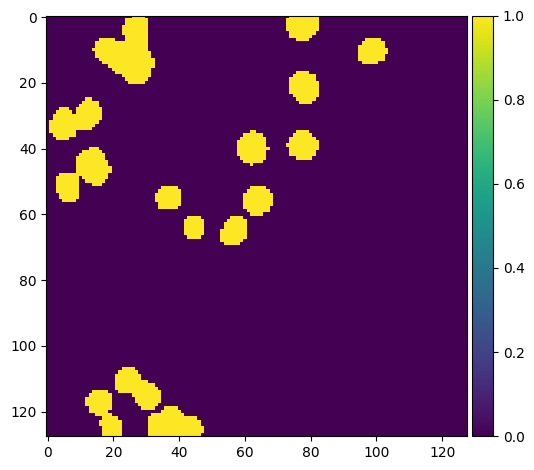

In [28]:
# Perform a sanity check on some random validation samples
# its not gonna perform that great as i made a mistake while creating validation set previously.
# It's fixed now in this notebook
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(y_train[int(y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

**Now Let's create the whole thing but with a predefined backbone like alexnet,vgg,resnet using segmentation-models library**